In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
sns.set()

%matplotlib inline

# Implementing the Seed-Connector algorithm

As per Supp info https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5453712/bin/jciinsight-2-93911-s001.pdf

- Step 1. Assume that the seed genes induce a subnetwork. Calculate the size of the largest connected
component (LCC) of the subnetwork.
- Step 2. Consider all the interactors of the seed genes as identified from the human interactome.
Add each interactor temporarily to the seed gene list one-by-one. Obtain the subnetwork induced
by this temporary seed gene list and determine the size of its LCC.
- Step 3. Select those interactors that can increase the coverage of seeds in the LCC of the
subnetwork maximally, and add them to the seed gene list.

In [2]:
class SeedConnector:
    def __init__(self, G, seeds):
        "Seed Connectorm algorithm, takes a PPI and a seed list as initializer"
        self.G = G # That is our PPI
        self.seeds = seeds # That is our seed list
        
    def getLCC(self, subG):
        "Return the largest connect component of a graph"
        largest_cc = max(nx.connected_components(subG), key=len)
        return largest_cc
    
    def getSubG(self, nodes):
        "Return the subgraph from a list of nodes"
        subG = self.G.subgraph(nodes)
        return subG
    
    def getNeighbors(self, subG):
        "Return the list of neighbors of a list of node"
        # Define a buffer array to hold the data
        neighbors = []
        # iterate over all the node in the subgraph
        for node in subG.nodes():
            # Grab all connected nodes to that node from the PPI
            neig = list(self.G[node].keys())
            # Add the new neighbors to the list of neighbors
            neighbors += [n for n in neig if n not in neighbors]
        # Filter out the nodes that are already in the module (no need to test it twice)
        neighbors = [n for n in neighbors if n not in subG.nodes()]
        return neighbors
    
    def run(self):
        "Run the Seed connector algorithm"
        t0 = time.time()
        # Get the seed subgraph
        subG = self.getSubG(self.seeds)
        # Get the seed subgraph LCC
        initLCC = self.getLCC(subG)
        # Save the size of the LCC as the old coverage (at the moment our LCC is the best we have)
        oldCoverage = len(initLCC)
        # Init the new size of the Coverage to 0 (will be updated in the update step below) 
        newCoverage = 0
        # Initialize the current module as the seeds
        module = [i for i in self.seeds]
        # Define a logger dictionary to store the data
        progress = {'Coverage':[], 'LCC':[], 'Size':[], 'step':{}, 'path':[]}
        # Define an iteration counter
        c = 0
        print("Starting with ",len(self.seeds)," seeds")
        print("{} are in the PPI".format(len(subG)))
        print("{} are missing".format([s for s in self.seeds if s not in subG]))
        # As long as adding nodes to the module increases the Coverage
        # Continue with a new iteration step
        while newCoverage != oldCoverage:
            # If the coverage is OVER the number of seeds we have saturated the module and stop
            if newCoverage > len(self.seeds):
                break
            # Save the newCoverage to the OldCoverage so we can compare between each step
            oldCoverage = newCoverage
            # Create a temporary result array
            result = []
            # We get the SubGraph of the current module
            subG = self.getSubG(module)
            # We get all the neighbors of the module
            neighbors = self.getNeighbors(subG)
            # Iterate over all the neighbors and calculate the result of adding this node
            for neig in neighbors:
                # Define the new new module
                newmodule = module + [neig]
                # Get the subGraph for this new module
                newsubG = self.getSubG(newmodule)
                # Get the LCC for this new module
                neigLCC = self.getLCC(newsubG)
                # Now we calculate the coverage of this module, we init coverage at 0
                coverage = 0
                # Iterate over all the seed genes
                for gene in self.seeds:
                    # If the seed gene is in the LCC of the new module
                    if gene in neigLCC:
                        # We increase the coverage by 1 
                        coverage += 1
                # We save this result into our temporary results list
                result.append((neig, coverage, len(neigLCC)))
            # We sort the results by coverage lambda x: x[0] -> gene name from above
            result = sorted(result, reverse=True, key=lambda x: x[0])
            # We grab the best coverage
            bestcoverage = max(result, key=lambda x: x[1])[1]
            # We fix the seed so we get repeatable randomness
            np.random.seed(65165744)
            # We take a random gene from the list of best genes, if there are multiple best genes
            bestgene = np.random.choice([gene[0] for gene in result if gene[1] == bestcoverage])
            # we select the max coverage -> [0][1] 
            newCoverage = bestcoverage
            # And save the LCC size
            LCC = [gene[2] for gene in result if gene[0] == bestgene][0]
            # And we add the new gene to our module
            module.append(bestgene)
            # We log all the values into our logging progress
            print("New coverage:", newCoverage, "Old coverage:", oldCoverage, "Module Size:", len(module), "LCC:", LCC)
            progress['Coverage'].append(newCoverage)
            progress['LCC'].append(LCC)
            progress['Size'].append(len(module))
            progress['step'][c] = module
            progress['path'].append(bestgene)
            # Increase our iteration step
            c+=1
            # Go back to the top and repeat until we cannot increase the coverage anymore.
        # Because the algorithm finishes on adding the "best" increase, the last step did not increase the coverage
        # But we still added the gene to the module list
        # Therefore we must remove the last added element
        module.pop()
        print("Execution time: ", time.time() - t0)
        return module, progress

# Loading the datasets

We load the different results from the 3 screens, the results from the prediction, the *Drodophila melanogaster* PPI network, and the signaling pathway information for each genes.


Accross the analysis the following names are used for the 3 screens
- ova == Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [3]:
datapath = '../Data/'
resultpath = '../Results'
PPI_ID = "2018_08"

In [4]:
G = nx.read_graphml(os.path.join(datapath, 'PPIs', 'PPI_{}.graphml'.format(PPI_ID)))
# G = nx.read_graphml(os.path.join("../../../Data/",'PPI.graphml'))

signaling = pd.read_csv(os.path.join(datapath, 'signaling.csv'))

hipo_ova = pd.read_csv(os.path.join(datapath, 'Screen', 'hipo_ova_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(datapath, 'Screen', 'hipo_fec_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(datapath, 'Screen', 'xRNAi_fec_clean.csv'))

# hipo_fec_pred = pd.read_csv(os.path.join(datapath, 'Screen','pred_hipo_fec_clean.csv')) 
# hipo_ova_pred = pd.read_csv(os.path.join(datapath, 'Screen','pred_hipo_ova_clean.csv'))
# xRNAi_fec_pred = pd.read_csv(os.path.join(datapath, 'Screen','pred_xRNAi_fec_clean.csv'))

## Calculate the mean for all datasets 

In [5]:
# Ovariole number screen
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
# mean_ova_gene_pred = hipo_ova_pred.groupby('FbID', as_index=False).mean()

# Hippo RNAi Egg Laying screen
mean_fec_gene = hipo_fec[hipo_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()
# mean_fec_gene_pred = hipo_fec_pred[hipo_fec_pred['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

# Egg Laying Screen
mean_xRNAi_gene = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()
# mean_xRNAi_gene_pred = xRNAi_fec_pred[xRNAi_fec_pred['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

## Define the list of genes that passes threshold cutoff

### Threshold definitions

In [6]:
ova_threshold = 2
eggl_threshold = 5

In [7]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
Zposneg_ova = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
Zposneg_ova = [i for i in Zposneg_ova if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_fec = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_fec = [i for i in Zposneg_fec if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_xRNAi = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_xRNAi = [i for i in Zposneg_xRNAi if 'FBgn' in i]

## Assert that we have the right number of positive candidates

In [8]:
assert(len(Zposneg_ova) == 67)
assert(len(Zposneg_fec) == 59)
assert(len(Zposneg_xRNAi) == 49)

# Building the modules using the Seed-Connector algorithm

In [9]:
def build_module(seed):
    "Build the module from a seed list"
    # Instanciate the algorithm with the PPI and the Ovariole network
    S = SeedConnector(G, seed)
    # Run the computation
    module, progress = S.run()
    # Plot the progress to make sure the algorithm worked as expected
    plt.plot(np.array(progress['LCC'])/np.array(progress['Size']))
    plt.xlabel("Algorithm steps")
    plt.ylabel("LCC/NetworkSize")
    return module

def decorate_module(seed, module, screenResults, pred=[], predResults=None):
    "Decorate the module Sub Graph with metadata"
    # Create the module by taking its subnetwork from the PPI
    subG = G.subgraph(module)
    # Iterate over the nodes
    for node in subG.nodes():
        # If the node is in the seeds decorate it as such
        if node in seed:
            # Grab the corresponding Zscore 
            Z = screenResults[screenResults['FbID'] == node]['Z'].values[0]
            if Z > 0:
                # If it's positive decorate 
                subG.node[node]['Seed'] = "Seed_Positive"
            else:
                # Else decorate 
                subG.node[node]['Seed'] = "Seed_Negative"
            # Save the Z value as absolute and real
            subG.node[node]['Z'] = float(Z)
            subG.node[node]['Zabs'] = abs(float(Z))
        # If the node is not in the seeds, it is a connector
        else:
            # If it is in the tested extra genes measure file
            if node in pred:
                # Get the Z score value
                Z = predResults[predResults['FbID'] == node]['Z'].values[0]
                subG.node[node]['Z'] = float(Z)
                subG.node[node]['Zabs'] = abs(float(Z))
            # Else set it at 0
            else:
                subG.node[node]['Z'] = 0.0

            # If the Z is > 0 decorate as Connector Positive
            if subG.node[node]['Z'] > 0:
                subG.node[node]['Seed'] = "Connector_Positive"
            # Or negative
            elif subG.node[node]['Z'] < 0:
                subG.node[node]['Seed'] = "Connector_Negative"
            # Or Unkown
            else:
                subG.node[node]['Seed'] = "Connector_Unknown"
    return subG

## Ovariole number module

In [10]:
# Define our seed list as the Ovariole Number Seed List
# And our data for decoration as screenResults = mean_ova_gene
seed = Zposneg_ova
screenResults = mean_ova_gene

Starting with  67  seeds
66 are in the PPI
['FBgn0002592'] are missing
New coverage: 46 Old coverage: 0 Module Size: 68 LCC: 47
New coverage: 50 Old coverage: 46 Module Size: 69 LCC: 52
New coverage: 52 Old coverage: 50 Module Size: 70 LCC: 55
New coverage: 54 Old coverage: 52 Module Size: 71 LCC: 58
New coverage: 56 Old coverage: 54 Module Size: 72 LCC: 61
New coverage: 58 Old coverage: 56 Module Size: 73 LCC: 64
New coverage: 59 Old coverage: 58 Module Size: 74 LCC: 66
New coverage: 60 Old coverage: 59 Module Size: 75 LCC: 68
New coverage: 61 Old coverage: 60 Module Size: 76 LCC: 70
New coverage: 62 Old coverage: 61 Module Size: 77 LCC: 72
New coverage: 63 Old coverage: 62 Module Size: 78 LCC: 74
New coverage: 63 Old coverage: 63 Module Size: 79 LCC: 75
Execution time:  166.97645831108093


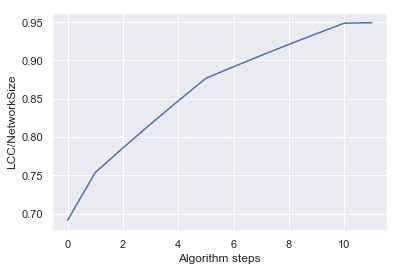

In [11]:
# Run the Seed Connector Algorithm and get the module
module_genes = build_module(seed)
# Decorate the module
module_network = decorate_module(seed, module_genes, screenResults)
# module_network = decorate_module(Zposneg_ova, module_genes, mean_ova_gene, pred=hipo_ova_pred['FbID'].unique(), predResults=mean_ova_gene_pred)

In [12]:
# Write the results to a graphml file
nx.write_graphml(module_network, os.path.join(resultpath, 'Ova_module_{}.graphml'.format(PPI_ID)))

## Hippo RNAi Egg Laying module

In [13]:
# Define our seed list as the HpoRNAi EggL Seed List
# And our data for decoration as screenResults = mean_fec_gene
seed = Zposneg_fec
screenResults = mean_fec_gene

Starting with  59  seeds
58 are in the PPI
['FBgn0037325'] are missing
New coverage: 31 Old coverage: 0 Module Size: 60 LCC: 32
New coverage: 35 Old coverage: 31 Module Size: 61 LCC: 37
New coverage: 38 Old coverage: 35 Module Size: 62 LCC: 41
New coverage: 41 Old coverage: 38 Module Size: 63 LCC: 45
New coverage: 43 Old coverage: 41 Module Size: 64 LCC: 48
New coverage: 44 Old coverage: 43 Module Size: 65 LCC: 50
New coverage: 45 Old coverage: 44 Module Size: 66 LCC: 52
New coverage: 46 Old coverage: 45 Module Size: 67 LCC: 54
New coverage: 47 Old coverage: 46 Module Size: 68 LCC: 56
New coverage: 48 Old coverage: 47 Module Size: 69 LCC: 58
New coverage: 49 Old coverage: 48 Module Size: 70 LCC: 60
New coverage: 50 Old coverage: 49 Module Size: 71 LCC: 62
New coverage: 51 Old coverage: 50 Module Size: 72 LCC: 64
New coverage: 52 Old coverage: 51 Module Size: 73 LCC: 66
New coverage: 53 Old coverage: 52 Module Size: 74 LCC: 68
New coverage: 54 Old coverage: 53 Module Size: 75 LCC: 70
Ne

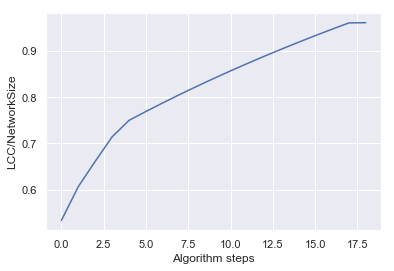

In [14]:
# Run the Seed Connector Algorithm and get the module
module_genes = build_module(seed)
# Decorate the module
module_network = decorate_module(seed, module_genes, screenResults)
# module_network = decorate_module(Zposneg_ova, module_genes, mean_ova_gene, pred=hipo_ova_pred['FbID'].unique(), predResults=mean_ova_gene_pred)

In [15]:
# Write the results to a graphml file
nx.write_graphml(module_network, os.path.join(resultpath, 'Hpo_EggL_module_{}.graphml'.format(PPI_ID)))

## Egg Laying module

In [16]:
# Define our seed list as the HpoRNAi EggL Seed List
# And our data for decoration as screenResults = mean_fec_gene
seed = Zposneg_xRNAi
screenResults = mean_xRNAi_gene

Starting with  49  seeds
49 are in the PPI
[] are missing
New coverage: 30 Old coverage: 0 Module Size: 50 LCC: 31
New coverage: 33 Old coverage: 30 Module Size: 51 LCC: 35
New coverage: 35 Old coverage: 33 Module Size: 52 LCC: 38
New coverage: 37 Old coverage: 35 Module Size: 53 LCC: 41
New coverage: 39 Old coverage: 37 Module Size: 54 LCC: 44
New coverage: 40 Old coverage: 39 Module Size: 55 LCC: 46
New coverage: 41 Old coverage: 40 Module Size: 56 LCC: 48
New coverage: 42 Old coverage: 41 Module Size: 57 LCC: 50
New coverage: 43 Old coverage: 42 Module Size: 58 LCC: 52
New coverage: 44 Old coverage: 43 Module Size: 59 LCC: 54
New coverage: 45 Old coverage: 44 Module Size: 60 LCC: 56
New coverage: 45 Old coverage: 45 Module Size: 61 LCC: 57
Execution time:  102.15508723258972


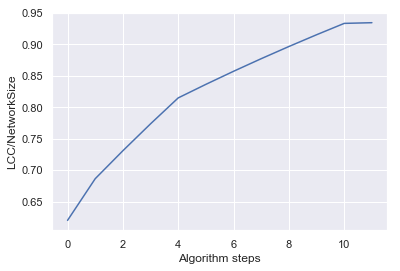

In [17]:
# Run the Seed Connector Algorithm and get the module
module_genes = build_module(seed)
# Decorate the module
module_network = decorate_module(seed, module_genes, screenResults)
# module_network = decorate_module(Zposneg_ova, module_genes, mean_ova_gene, pred=hipo_ova_pred['FbID'].unique(), predResults=mean_ova_gene_pred)

In [18]:
# Write the results to a graphml file
nx.write_graphml(module_network, os.path.join(resultpath, 'EggL_module_{}.graphml'.format(PPI_ID)))

## Core Module
Core is defined as the module composed of the overlapping set of positive candidate of the 3 screens. Only if the gene was positive in all 3 screens

In [19]:
# We take the interesection of the positive canditate of the 3 screens. 
core_genes = set.intersection(set(Zposneg_ova), set(Zposneg_fec), set(Zposneg_xRNAi))

In [20]:
assert(len(mean_ova_gene[mean_ova_gene['FbID'].isin(core_genes)]) == len(mean_xRNAi_gene[mean_xRNAi_gene['FbID'].isin(core_genes)]) == len(mean_fec_gene[mean_fec_gene['FbID'].isin(core_genes)]))

### Here we make the decision to decorate the Core module with the Z value from the Ovariole Number Screen

In [21]:
seed = core_genes
screenResults = mean_ova_gene

Starting with  27  seeds
27 are in the PPI
[] are missing
New coverage: 13 Old coverage: 0 Module Size: 28 LCC: 14
New coverage: 16 Old coverage: 13 Module Size: 29 LCC: 18
New coverage: 19 Old coverage: 16 Module Size: 30 LCC: 22
New coverage: 20 Old coverage: 19 Module Size: 31 LCC: 24
New coverage: 21 Old coverage: 20 Module Size: 32 LCC: 26
New coverage: 22 Old coverage: 21 Module Size: 33 LCC: 28
New coverage: 23 Old coverage: 22 Module Size: 34 LCC: 30
New coverage: 24 Old coverage: 23 Module Size: 35 LCC: 32
New coverage: 25 Old coverage: 24 Module Size: 36 LCC: 34
New coverage: 26 Old coverage: 25 Module Size: 37 LCC: 36
New coverage: 26 Old coverage: 26 Module Size: 38 LCC: 37
Execution time:  61.97297024726868


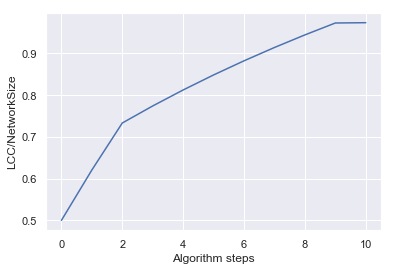

In [22]:
# Run the Seed Connector Algorithm and get the module
module_genes = build_module(seed)
# Decorate the module
module_network = decorate_module(seed, module_genes, screenResults)
# module_network = decorate_module(Zposneg_ova, module_genes, mean_ova_gene, pred=hipo_ova_pred['FbID'].unique(), predResults=mean_ova_gene_pred)

In [23]:
nx.write_graphml(module_network, os.path.join(resultpath, 'Core_module_{}.graphml'.format(PPI_ID)))

# Stats about the modules

In [24]:
PPI_ID = "2018_08"

In [25]:
# Modules computed above
ova_module_G = nx.read_graphml(os.path.join(resultpath,'Ova_module_{}.graphml'.format(PPI_ID)))
fec_module_G = nx.read_graphml(os.path.join(resultpath,'Hpo_EggL_module_{}.graphml'.format(PPI_ID)))
xRNAi_module_G = nx.read_graphml(os.path.join(resultpath,'EggL_module_{}.graphml'.format(PPI_ID)))
core_module_G = nx.read_graphml(os.path.join(resultpath,'Core_module_{}.graphml'.format(PPI_ID)))

In [26]:
print("HpoRNAi Ovariole Module has {} genes in it.".format(len(ova_module_G)))
print("HpoRNAi EggL Module has {} genes in it.".format(len(fec_module_G)))
print("EggL Module has {} genes in it.".format(len(xRNAi_module_G)))
print("Core Module has {} genes in it.".format(len(core_module_G)))

HpoRNAi Ovariole Module has 77 genes in it.
HpoRNAi EggL Module has 76 genes in it.
EggL Module has 60 genes in it.
Core Module has 37 genes in it.


In [27]:
# Here we extract all the connectors
connectors = []

# For each node in a module graph
for node in ova_module_G.node:
    # If this node has the Connector Tag in the Seed Tag
    if "Connector" in ova_module_G.node[node]['Seed']:
        # Save it as a connector
        connectors.append(['Ova',node])
for node in fec_module_G.node:
    if "Connector" in fec_module_G.node[node]['Seed']:
        connectors.append(['HpoFec',node])
for node in xRNAi_module_G.node:
    if "Connector" in xRNAi_module_G.node[node]['Seed']:
        connectors.append(['xRNAiFec',node])
for node in core_module_G.node:
    if "Connector" in core_module_G.node[node]['Seed']:
        connectors.append(['Core',node])

connectors = pd.DataFrame(connectors, columns=['Module', 'FbID'])
connectors.to_csv(os.path.join(resultpath,"ConnectorGeneList_{}.csv".format(PPI_ID)), index=False)

In [28]:
print("There is {} unique connectors found accross the 4 network modules".format(len(connectors['FbID'].unique())))

There is 43 unique connectors found accross the 4 network modules


In [29]:
connectors.groupby("Module").count()

,FbID
Module,
Core,10
HpoFec,18
Ova,11
xRNAiFec,11


# Making a table of all the modules

In [30]:
table = []

# For each node in a module graph
for node in ova_module_G.node:
    tmp = [node, ova_module_G.node[node]['label'], ova_module_G.node[node]['Seed'], ova_module_G.node[node]['Z']]
    table.append(tmp)
    
for node in fec_module_G.node:
    tmp = [node, fec_module_G.node[node]['label'], fec_module_G.node[node]['Seed'], fec_module_G.node[node]['Z']]
    table.append(tmp)

for node in xRNAi_module_G.node:
    tmp = [node, xRNAi_module_G.node[node]['label'], xRNAi_module_G.node[node]['Seed'], xRNAi_module_G.node[node]['Z']]
    table.append(tmp)

for node in core_module_G.node:
    tmp = [node, core_module_G.node[node]['label'], core_module_G.node[node]['Seed'], core_module_G.node[node]['Z']]
    table.append(tmp)

table = pd.DataFrame(table, columns=['FbID', 'Label', 'SeedStatus', 'Z'])

In [31]:
table.to_csv(os.path.join(resultpath, "Modules_Table_{}.csv".format(PPI_ID)), index=False)